# Visual Plant Recognition

This Jupyter Notebook uses a pre-trained Inception v3 architecture to train on the [Oxford 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 different plants. PyTorch is used as a framework.

## Dataset Loading

Importing all the necessary frameworks, libraries and classes

In [1]:
from pathlib import Path
import copy
from matplotlib import pyplot as plt
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import KFold
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import platform 

from helper import convert_mat_to_csv, counting_labels
from dataset_loader import Oxford102Dataset, Rescale, RandomCrop, ToTensor, Normalize
from visualization import image_visualization, batch_visualization, class_balance_visualization
from model import SimpleNet, resNet_152
from training import train_epoch
from evaluation import evaluation

/Users/darkotomasic/micromamba/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/darkotomasic/micromamba/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/darkotomasic/micromamba/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/ec2-user/actions-runner/_work/vision/vision/conda-env-2408739877/lib/libpng16.16.dylib' (no such file), '/Users/ec2-user/actions-runner/_work/vision/vision/conda-env-2408739877/lib/libpng16.16.dylib' (no such file), '/Users/ec2-user/actions-runner/_work/vision/vision/conda-env-2408739877/lib/libpng16.16.dylib' (no such file), '/Users/ec2-user/actions-runner/_work/vision/vision/conda-env-2408739877/lib/libpng16.16.dylib' (no such file), '/Users/darkotomasic/micromamba/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/darkotomasic/micromamba/bin/../lib/libpng16.16.d

In [2]:
#print(platform.platform())
#print(torch.has_mps)

Converting the MatLab files with the labels into a csv

In [3]:
path_dataset = Path("../dataset/")
if not(path_dataset.joinpath("imagelabels.csv").exists()):
    convert_mat_to_csv(path_dataset.joinpath("imagelabels.mat"))
    print("Created image labels")
else: 
    print("Image labels already exist as csv")
if not(path_dataset.joinpath("setid.csv").exists()):    
    convert_mat_to_csv(path_dataset.joinpath("setid.mat"))
    print("Created set id")
else: 
    print("Set id already exist as csv")

Image labels already exist as csv
Set id already exist as csv


Visualization of the dataset

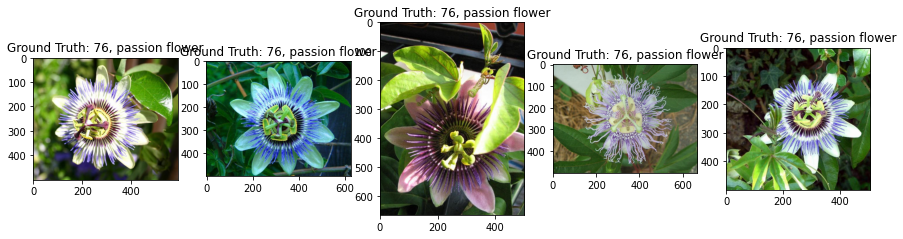

In [4]:
oxford102Dataset = Oxford102Dataset(csv_file='../dataset/imagelabels.csv',
                                    dataset_dir='../dataset/')

batch_visualization(oxford102Dataset, (1, 5), (15, 4))
    


Checking for class balance

In [2]:
class_sample_counts = counting_labels(filename='../dataset/imagelabels.csv')
class_balance_visualization(class_sample_counts)

<class 'dict'>
{1: 40, 2: 60, 3: 40, 4: 56, 5: 65, 6: 45, 7: 40, 8: 85, 9: 46, 10: 45, 11: 87, 12: 87, 13: 49, 14: 48, 15: 49, 16: 41, 17: 85, 18: 82, 19: 49, 20: 56, 21: 40, 22: 59, 23: 91, 24: 42, 25: 41, 26: 41, 27: 40, 28: 66, 29: 78, 30: 85, 31: 52, 32: 45, 33: 46, 34: 40, 35: 43, 36: 75, 37: 108, 38: 56, 39: 41, 40: 67, 41: 127, 42: 59, 43: 130, 44: 93, 45: 40, 46: 196, 47: 67, 48: 71, 49: 49, 50: 92, 51: 258, 52: 85, 53: 93, 54: 61, 55: 71, 56: 109, 57: 67, 58: 114, 59: 67, 60: 109, 61: 50, 62: 55, 63: 54, 64: 52, 65: 102, 66: 61, 67: 42, 68: 54, 69: 54, 70: 62, 71: 78, 72: 96, 73: 194, 74: 171, 75: 120, 76: 107, 77: 251, 78: 137, 79: 41, 80: 105, 81: 166, 82: 112, 83: 131, 84: 86, 85: 63, 86: 58, 87: 63, 88: 154, 89: 184, 90: 82, 91: 76, 92: 66, 93: 46, 94: 162, 95: 128, 96: 91, 97: 66, 98: 82, 99: 63, 100: 49, 101: 58, 102: 48}


<Figure size 432x288 with 0 Axes>

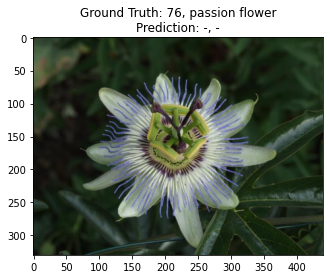

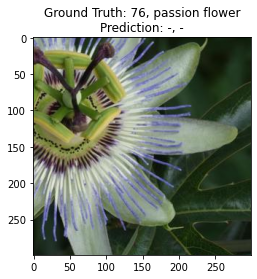

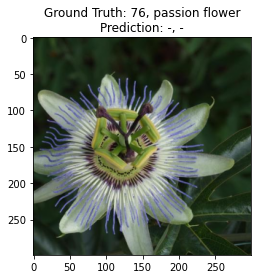

In [5]:
scale = Rescale(330)
crop = RandomCrop(299)
composed = transforms.Compose([Rescale(330),
                               RandomCrop(299)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = oxford102Dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    image_visualization(transformed_sample['image'], sample['plant_label'])


plt.show()

Putting everything together and iterating trough the dataset with dataloader

Loading the Oxford 102 Dataset with a custome dataloader and visualise it

In [6]:
transformed_dataset = Oxford102Dataset(csv_file='../dataset/imagelabels.csv',
                                    dataset_dir='../dataset/', transform=transforms.Compose([
        RandomCrop(224),
        ToTensor(),
        Normalize()]))

train_len = int(0.8 * len(transformed_dataset))
train_data, test_data = random_split(transformed_dataset, [train_len, 
                                                           len(transformed_dataset)-train_len], 
                                                             generator=torch.Generator().manual_seed(1))
train_dataloader = DataLoader(train_data, batch_size=32,
                        shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=32,
                        shuffle=True, num_workers=4)

## Training

In [7]:
# instanciate model
model = SimpleNet()

# move model to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()

# move model to Apple Silicon GPU if available
#device = torch.device('mps')
#if device:
   # model.to(device)
#device
    
# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

In [9]:
def train(n_epochs, train_dataset, model, optimizer, loss_function, use_cuda, use_mps, batch_size=32, k_splits = 5):
    # tensorboard
    writer = SummaryWriter()

    # cross validation
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    kfold = KFold(n_splits=k_splits, shuffle=True, random_state=1)
    for fold, (train_idx, test_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_subsampler)
        
        model.apply(init_weights)

        for epoch in range(1, n_epochs+1):
            train_epoch(model, train_dataloader, optimizer, loss_function, use_cuda, use_mps)
            loss, accuracy = evaluation(model, train_dataloader, loss_function, use_cuda, use_mps)
            valid_loss, valid_accuracy = evaluation(model, valid_dataloader, loss_function, use_cuda, use_mps)

            
            writer.add_scalars(f'Loss/fold: {fold + 1}', {'training': loss, 'validation': valid_loss}, global_step=epoch)
            writer.add_scalars(f'Accuracy/fold : {fold + 1}', {'training': accuracy, 'validation': valid_accuracy}, global_step=epoch)
            
            #TODO richtige Ausgabe
            print(f"Split {fold + 1}, Epoch {epoch} - Loss: {loss} - Acc: {accuracy}")
            
        valid_loss, valid_accuracy = evaluation(model, valid_dataloader, loss_function, use_cuda, use_mps)
        if  valid_accuracy > best_acc:
                best_acc = valid_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print("Saved model")
    return model


In [10]:
# train the model
model_scratch = train(15, train_data, model, optimizer, 
                      loss_function, use_cuda, use_mps=False, k_splits=2)

Split 1, Epoch 1 - Loss: 4.529162703208553 - Acc: 2.336164951324463
Split 1, Epoch 2 - Loss: 4.516240610659701 - Acc: 3.3980581760406494
Split 1, Epoch 3 - Loss: 4.502454030860975 - Acc: 2.9733009338378906
Split 1, Epoch 4 - Loss: 4.480576580010571 - Acc: 3.549757242202759
Split 1, Epoch 5 - Loss: 4.2058128292120776 - Acc: 5.218446731567383
Split 1, Epoch 6 - Loss: 4.102333520222636 - Acc: 5.218446731567383
Split 1, Epoch 7 - Loss: 4.032276153564453 - Acc: 6.553398132324219
Split 1, Epoch 8 - Loss: 3.889613737180395 - Acc: 7.402912616729736
Split 1, Epoch 9 - Loss: 3.780706813034502 - Acc: 9.041261672973633
Split 1, Epoch 10 - Loss: 3.6989073614472323 - Acc: 11.650485038757324
Split 1, Epoch 11 - Loss: 3.6312644389069195 - Acc: 12.166261672973633
Split 1, Epoch 12 - Loss: 3.583544071438243 - Acc: 13.925971031188965
Split 1, Epoch 13 - Loss: 3.457123717058052 - Acc: 14.593446731567383
Split 1, Epoch 14 - Loss: 3.411746633862986 - Acc: 14.168689727783203
Split 1, Epoch 15 - Loss: 3.28928

In [ ]:
model_resnet152 = resNet_152(1000, 7)
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_resnet152.cuda()

# move model to Apple Silicon GPU if available
#device = torch.device('mps')
#if device:
    #model_resnet152.to(device)
device

/Users/darkotomasic/micromamba/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/darkotomasic/micromamba/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 child 0 is -
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is -
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is -
ReLU(inplace=True)
 child 3 is -
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is -
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fals

device(type='mps')

In [12]:
model_scratch = train(5, train_data, model, optimizer, 
                      loss_function, use_cuda, use_mps=False, k_splits=2)

NotImplementedError: The operator 'aten::_slow_conv2d_forward' is not current implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.